In [50]:
!pip install biopython
!pip install transformers

In [0]:
import os
import gzip
from Bio import SeqIO
from Bio.Data import CodonTable

import torch

from transformers import GPT2Config, GPT2Model, GPT2LMHeadModel

In [52]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def check_known_protein(protein_description):
    """filter out hypothetical and putative proteins"""
    is_hypothetical = ('hypoth' in protein_description or 'hetical' in protein_description) # deals with most common misspellings of "hypothetical"
    is_putative = 'putative' in protein_description
    is_known = (not is_hypothetical) and (not is_putative)
    return is_known

def get_CDS_locations(genome_path):
    """exctracts gene locations and seqs from known protein coding genes, only non-hypothetical"""
    gene_loc_list = []
    gene_seq_list = []
    with gzip.open(genome_path, 'rt') as handle: # open file
        for record in SeqIO.parse(handle, "genbank"): # parse each record within file
            feature_list = record.features
            CDS_list = [x for x in feature_list if x.type=='CDS'] # get all CDS features in record
            for CDS in CDS_list:
                try:
                    protein_description = CDS.qualifiers['product'][0]
                    if check_known_protein(protein_description): # only use non-hypothetical proteins
                        gene_loc = CDS.location
                        gene_loc_list.append(gene_loc)

                        gene_seq = CDS.extract(record.seq) # extract locations of CDS
                        gene_seq_list.append(gene_seq)
                except:
                    pass

    return gene_loc_list, gene_seq_list

In [54]:
# load fasta sequence
d = "drive/My Drive/Colab Notebooks/smaug/data/ecoli_MG1655"
genome_path = os.path.join(d, "GCF_000005845.2_ASM584v2_genomic.fna.gz")

with gzip.open(genome_path, 'rt') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq = record.seq

# get gene locations
gbff_path = os.path.join(d, "GCF_000005845.2_ASM584v2_genomic.gbff.gz")
gene_loc_list, gene_seq_list = get_CDS_locations(gbff_path)

# total genes and example loc
print(len(gene_loc_list))
print(gene_loc_list[300])

3532
[381350:381716](+)


In [55]:
# all code needed to produce score for "geneness" of amino acid sequence

# mount
from google.colab import drive
drive.mount('/content/drive')
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models"
modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/10-25-19_morning_20"

# load model
model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')

# score sequence
def score_seq(aa_seq_string):
    aa_seq_string = aa_seq_string[:40] ################### TODO implement shingles
    
    token = tokenize_aa_seq(aa_seq_string)
    input_ids = token.unsqueeze(0).to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1
    
    correctmask = predval == input_ids[:] # why no offset here?
    hardcorrect = torch.sum(correctmask).item()
    totalcorrect = logits.shape[0]*logits.shape[1]

    softcorrect = 0
    for i in range(input_ids.shape[0]):
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]
    softcorrect = softcorrect.item()

    softproportion = softcorrect/totalcorrect 
    hardproportion = hardcorrect/totalcorrect

    return softproportion # hard proportion might work better on long sequences

def tokenize_aa_seq(aa_seq):
    """Convert amino acid letters to integers. Can also use murphy's reduced aa alphabet later"""
    table = {"L":1,
             "V":2,
             "I":3,
             "M":4,
             "C":5,
             "A":6,
             "G":7,
             "S":8,
             "T":9,
             "P":10,
             "F":11,
             "Y":12,
             "W":13,
             "E":14,
             "D":15,
             "N":16,
             "Q":17,
             "K":18,
             "R":19,
             "H":20,
             "X":0, # get rid of these
             "B":0,
             "*":0}
    tokenized = torch.tensor([table[aa] for aa in aa_seq])
    return tokenized

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# find all ORFs in all reading frames
# TODO: ORFs can contain smaller ORFs with alternative start codons, which may be the true start codons. Need to extract all possible ORFs to find all true genes
def find_ORFs(aa_seq, minimum_length):
    """find positions of all open reading frames in all reading frames"""
    # ASSUMES AMINO ACID SEQUENCE IS 5' to 3'
    ORF_startstop = []
    started = False
    startpos = -1
    for i, c in enumerate(aa_seq):
        if c == "M" and not started:
            startpos = i
            started = True
            continue
        if c == "*":
            if started and (i-startpos >= minimum_length):
                ORF_startstop.append((startpos, i))
            started = False
    return ORF_startstop # TODO may be better to use dict rather than tuple list


# amino acid seqs for all 6 reading frames
# trimming last nucs to ensure multiple of 3
aa_seq_0f = str(seq[:len(seq)-(len(seq)%3)].translate(table=11, to_stop=False))
aa_seq_1f = str(seq[1:len(seq)-((len(seq)-1)%3)].translate(table=11, to_stop=False))
aa_seq_2f = str(seq[2:len(seq)-((len(seq)-2)%3)].translate(table=11, to_stop=False))
aa_seq_0r = str(seq.reverse_complement()[:len(seq)-(len(seq)%3)].translate(table=11, to_stop=False)) #TODO cut end off before or after reverse complement?
aa_seq_1r = str(seq.reverse_complement()[1:len(seq)-((len(seq)-1)%3)].translate(table=11, to_stop=False))
aa_seq_2r = str(seq.reverse_complement()[2:len(seq)-((len(seq)-2)%3)].translate(table=11, to_stop=False))

# ORFs starts and stops in all reading frames, use to access sequence
minimum_length = 10
ORF_0f = find_ORFs(aa_seq_0f, minimum_length)
ORF_1f = find_ORFs(aa_seq_1f, minimum_length)
ORF_2f = find_ORFs(aa_seq_2f, minimum_length)
ORF_0r = find_ORFs(aa_seq_0r, minimum_length)
ORF_1r = find_ORFs(aa_seq_1r, minimum_length)
ORF_2r = find_ORFs(aa_seq_2r, minimum_length)

# standardize coordinates of all ORFs
nuclen = len(seq)
ORF_0f_standard_nuccoord = [(x[0]*3, x[1]*3) for x in ORF_0f]
ORF_1f_standard_nuccoord = [(x[0]*3+1, x[1]*3+1) for x in ORF_1f]
ORF_2f_standard_nuccoord = [(x[0]*3+2, x[1]*3+2) for x in ORF_2f]
ORF_0r_standard_nuccoord = [(nuclen-x[1]*3, nuclen-x[0]*3) for x in ORF_0r]
ORF_1r_standard_nuccoord = [(nuclen-x[1]*3-1, nuclen-x[0]*3-1) for x in ORF_1r]
ORF_2r_standard_nuccoord = [(nuclen-x[1]*3-2, nuclen-x[0]*3-2) for x in ORF_2r]


In [96]:
# example translation of ORF from genomic coordinates
# orf = ORF_0f_standard_nuccoord[1000]
# orf = ORF_1f_standard_nuccoord[100]
# orf = ORF_2f_standard_nuccoord[100]
# orf = ORF_0r_standard_nuccoord[100]
# orf = ORF_1r_standard_nuccoord[107]
orf = ORF_2r_standard_nuccoord[197]

print(orf)
print()

print(seq[slice(*orf)].translate(table=11, to_stop=False))
endcoord = orf[1]
print(seq[endcoord:endcoord+3].translate(table=11, to_stop=False))
print()

print(seq[slice(*orf)].reverse_complement().translate(table=11, to_stop=False))
endcoord = orf[0]
print(seq[endcoord-3:endcoord].reverse_complement().translate(table=11, to_stop=False))


(4540169, 4540208)

VFTRHQAEHNSHH
E

MMRIMLSLMAGKH
*


In [0]:
# check if predicted gene matches 3' end, also if 5' (correct start codon is harder)
allstops_real = 
allstarts_real = 

In [0]:
for i in range(10):
    print(gene_loc_list[i])
    print(gene_loc_list[i].start)


[189:255](+)
189
[336:2799](+)
336
[2800:3733](+)
2800
[3733:5020](+)
3733
[5233:5530](+)
5233
[5682:6459](-)
5682
[8237:9191](+)
8237
[9305:9893](+)
9305
[9927:10494](-)
9927
[10829:11315](+)
10829


In [0]:
# example scores
import matplotlib.pyplot as plt
# score_0f = [score_seq(aa_seq_0f[x[0]:x[1]][::-1]) for x in ORF_0f[:1000]]
# score_1f = [score_seq(aa_seq_1f[x[0]:x[1]][::-1]) for x in ORF_1f[:1000]]
score_0r = [score_seq(aa_seq_0r[x[0]:x[1]]) for x in ORF_0f[:300]] # TODO CHECK WHETHER REVERSE OF STRING SHOULD BE USED FOR R seqs


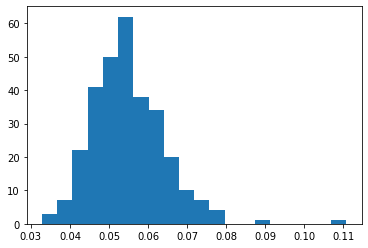

In [0]:
# plt.hist(score_0f, bins=100)
# plt.show()
# plt.hist(score_1f, bins=100)
# plt.show()
plt.hist(score_0r, bins=20)
plt.show()

In [0]:
# greedy search to find non-overlapping genes based solely on length
